In [209]:
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from redditClient import redditClient
# import praw
# from praw.models import MoreComments
from collections import Counter
import string
import json
import codecs
import re
import time
import sys
import datetime

# from redditscore.tokenizer import CrazyTokenizer

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rakya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [221]:
data_colnames = ["text", "datetime", "replies", "views"]
data_ronaldo_raw = pd.read_csv('data_ronaldo_rep_view_final.csv', names=data_colnames)
data_messi_raw = pd.read_csv('data_messi_rep_view_final.csv', names=data_colnames)
print("Length of data for ronaldo =", len(data_ronaldo_raw))
print("Length of data for messi =", len(data_messi_raw))
regexpr = r'\w+' # Regular Expression for tokenizer
num_freq_term = 25

Length of data for ronaldo = 8021
Length of data for messi = 2977


Cleaning data

In [222]:
data_ronaldo_raw

,text,datetime,replies,views
0,with UEFA over groundbreaking Champions League...,"Mon Aug 28, 2023 6:30 pm",20,2392
1,with UEFA over groundbreaking Champions League...,"Wed Aug 23, 2023 5:21 pm",20,2392
2,ronaldo is a legend in his own lunchbox. ten h...,"Fri Apr 14, 2023 11:30 pm",41,3674
3,consistency but are never going to get it. Can...,"Sun Jan 15, 2023 10:13 am",776,49856
4,"pass is exceptional, I think he is better than...","Tue Dec 20, 2022 10:54 am",14,1835
...,...,...,...,...
8016,Ronaldo deal definetely off. Milan said the pr...,"Sun Aug 27, 2006 10:25 am",15,1886
8017,The Italian giants have been in talks with Rea...,"Sat Aug 26, 2006 11:31 am",15,1886
8018,Ronaldo you really are a silly boy. The gunner...,"Fri Aug 25, 2006 4:52 pm",31,9042
8019,of the season i would believe that bellamy wou...,"Thu Aug 24, 2006 8:29 pm",41,14797


In [223]:
data_messi_raw

,text,datetime,replies,views
0,"at the same time, or they can watch Vanilla Ar...","Thu Jun 15, 2023 1:52 pm",12,1339
1,"at the same time, or they can watch Vanilla Ar...","Wed Jun 14, 2023 1:38 pm",12,1339
2,$400 Million????,"Fri May 05, 2023 10:52 am",2,1173
3,Messi Gonski 1.95507632,"Wed May 03, 2023 11:11 pm",2,1173
4,"bloody professional footballers, but they stil...","Mon Jan 23, 2023 9:15 pm",776,49856
...,...,...,...,...
2972,"65th minute of the Group A game. Barcelona, th...","Thu Sep 28, 2006 5:44 pm",0,610
2973,Messi dispossed and out run by Kaka for the th...,"Mon Sep 04, 2006 7:21 am",6,2556
2974,finally a journalist who has the same opinion ...,"Sun Sep 03, 2006 11:46 am",6,2486
2975,but were pushed all the way by their opponents...,"Wed Aug 30, 2006 2:30 pm",2,1659


In [224]:
data_clean_text_ronaldo = data_ronaldo_raw[data_ronaldo_raw['text'].str.len() >= 50]
data_clean_text_messi = data_messi_raw[data_messi_raw['text'].str.len() >= 50]

In [225]:
print(len(data_clean_text_ronaldo), len(data_clean_text_messi))

6717 2371


In [226]:
data_clean_datetime_ronaldo = data_clean_text_ronaldo.join(data_clean_text_ronaldo['datetime'].str.split(expand=True).rename(columns={0:'day', 1:'month', 2:'date', 3:'year', 4:'time', 5:'ampm'}))
data_clean_datetime_messi = data_clean_text_messi.join(data_clean_text_messi['datetime'].str.split(expand=True).rename(columns={0:'day', 1:'month', 2:'date', 3:'year', 4:'time', 5:'ampm'}))

In [227]:
data_clean_datetime_ronaldo

,text,datetime,replies,views,day,month,date,year,time,ampm
0,with UEFA over groundbreaking Champions League...,"Mon Aug 28, 2023 6:30 pm",20,2392,Mon,Aug,"28,",2023,6:30,pm
1,with UEFA over groundbreaking Champions League...,"Wed Aug 23, 2023 5:21 pm",20,2392,Wed,Aug,"23,",2023,5:21,pm
2,ronaldo is a legend in his own lunchbox. ten h...,"Fri Apr 14, 2023 11:30 pm",41,3674,Fri,Apr,"14,",2023,11:30,pm
3,consistency but are never going to get it. Can...,"Sun Jan 15, 2023 10:13 am",776,49856,Sun,Jan,"15,",2023,10:13,am
4,"pass is exceptional, I think he is better than...","Tue Dec 20, 2022 10:54 am",14,1835,Tue,Dec,"20,",2022,10:54,am
...,...,...,...,...,...,...,...,...,...,...
8016,Ronaldo deal definetely off. Milan said the pr...,"Sun Aug 27, 2006 10:25 am",15,1886,Sun,Aug,"27,",2006,10:25,am
8017,The Italian giants have been in talks with Rea...,"Sat Aug 26, 2006 11:31 am",15,1886,Sat,Aug,"26,",2006,11:31,am
8018,Ronaldo you really are a silly boy. The gunner...,"Fri Aug 25, 2006 4:52 pm",31,9042,Fri,Aug,"25,",2006,4:52,pm
8019,of the season i would believe that bellamy wou...,"Thu Aug 24, 2006 8:29 pm",41,14797,Thu,Aug,"24,",2006,8:29,pm


In [228]:
data_clean_datetime_messi

,text,datetime,replies,views,day,month,date,year,time,ampm
0,"at the same time, or they can watch Vanilla Ar...","Thu Jun 15, 2023 1:52 pm",12,1339,Thu,Jun,"15,",2023,1:52,pm
1,"at the same time, or they can watch Vanilla Ar...","Wed Jun 14, 2023 1:38 pm",12,1339,Wed,Jun,"14,",2023,1:38,pm
4,"bloody professional footballers, but they stil...","Mon Jan 23, 2023 9:15 pm",776,49856,Mon,Jan,"23,",2023,9:15,pm
5,Been saying the same about Messi for along tim...,"Mon Jan 23, 2023 8:00 pm",776,49856,Mon,Jan,"23,",2023,8:00,pm
6,A great final. Well played by both. Two champi...,"Mon Dec 19, 2022 10:46 pm",546,30873,Mon,Dec,"19,",2022,10:46,pm
...,...,...,...,...,...,...,...,...,...,...
2972,"65th minute of the Group A game. Barcelona, th...","Thu Sep 28, 2006 5:44 pm",0,610,Thu,Sep,"28,",2006,5:44,pm
2973,Messi dispossed and out run by Kaka for the th...,"Mon Sep 04, 2006 7:21 am",6,2556,Mon,Sep,"04,",2006,7:21,am
2974,finally a journalist who has the same opinion ...,"Sun Sep 03, 2006 11:46 am",6,2486,Sun,Sep,"03,",2006,11:46,am
2975,but were pushed all the way by their opponents...,"Wed Aug 30, 2006 2:30 pm",2,1659,Wed,Aug,"30,",2006,2:30,pm


In [229]:
data_clean_datetime_ronaldo = data_clean_datetime_ronaldo.join(data_clean_datetime_ronaldo['time'].str.split(':', expand=True).rename(columns={0:'hour', 1:'minute'})).reset_index(drop=True)
data_clean_datetime_messi = data_clean_datetime_messi.join(data_clean_datetime_messi['time'].str.split(':', expand=True).rename(columns={0:'hour', 1:'minute'})).reset_index(drop=True)

In [230]:
data_clean_datetime_ronaldo

,text,datetime,replies,views,day,month,date,year,time,ampm,hour,minute
0,with UEFA over groundbreaking Champions League...,"Mon Aug 28, 2023 6:30 pm",20,2392,Mon,Aug,"28,",2023,6:30,pm,6,30
1,with UEFA over groundbreaking Champions League...,"Wed Aug 23, 2023 5:21 pm",20,2392,Wed,Aug,"23,",2023,5:21,pm,5,21
2,ronaldo is a legend in his own lunchbox. ten h...,"Fri Apr 14, 2023 11:30 pm",41,3674,Fri,Apr,"14,",2023,11:30,pm,11,30
3,consistency but are never going to get it. Can...,"Sun Jan 15, 2023 10:13 am",776,49856,Sun,Jan,"15,",2023,10:13,am,10,13
4,"pass is exceptional, I think he is better than...","Tue Dec 20, 2022 10:54 am",14,1835,Tue,Dec,"20,",2022,10:54,am,10,54
...,...,...,...,...,...,...,...,...,...,...,...,...
6712,Ronaldo deal definetely off. Milan said the pr...,"Sun Aug 27, 2006 10:25 am",15,1886,Sun,Aug,"27,",2006,10:25,am,10,25
6713,The Italian giants have been in talks with Rea...,"Sat Aug 26, 2006 11:31 am",15,1886,Sat,Aug,"26,",2006,11:31,am,11,31
6714,Ronaldo you really are a silly boy. The gunner...,"Fri Aug 25, 2006 4:52 pm",31,9042,Fri,Aug,"25,",2006,4:52,pm,4,52
6715,of the season i would believe that bellamy wou...,"Thu Aug 24, 2006 8:29 pm",41,14797,Thu,Aug,"24,",2006,8:29,pm,8,29


In [231]:
data_clean_datetime_messi

,text,datetime,replies,views,day,month,date,year,time,ampm,hour,minute
0,"at the same time, or they can watch Vanilla Ar...","Thu Jun 15, 2023 1:52 pm",12,1339,Thu,Jun,"15,",2023,1:52,pm,1,52
1,"at the same time, or they can watch Vanilla Ar...","Wed Jun 14, 2023 1:38 pm",12,1339,Wed,Jun,"14,",2023,1:38,pm,1,38
2,"bloody professional footballers, but they stil...","Mon Jan 23, 2023 9:15 pm",776,49856,Mon,Jan,"23,",2023,9:15,pm,9,15
3,Been saying the same about Messi for along tim...,"Mon Jan 23, 2023 8:00 pm",776,49856,Mon,Jan,"23,",2023,8:00,pm,8,00
4,A great final. Well played by both. Two champi...,"Mon Dec 19, 2022 10:46 pm",546,30873,Mon,Dec,"19,",2022,10:46,pm,10,46
...,...,...,...,...,...,...,...,...,...,...,...,...
2366,"65th minute of the Group A game. Barcelona, th...","Thu Sep 28, 2006 5:44 pm",0,610,Thu,Sep,"28,",2006,5:44,pm,5,44
2367,Messi dispossed and out run by Kaka for the th...,"Mon Sep 04, 2006 7:21 am",6,2556,Mon,Sep,"04,",2006,7:21,am,7,21
2368,finally a journalist who has the same opinion ...,"Sun Sep 03, 2006 11:46 am",6,2486,Sun,Sep,"03,",2006,11:46,am,11,46
2369,but were pushed all the way by their opponents...,"Wed Aug 30, 2006 2:30 pm",2,1659,Wed,Aug,"30,",2006,2:30,pm,2,30


In [232]:
for i in range(len(data_clean_datetime_ronaldo)):
    if data_clean_datetime_ronaldo['ampm'][i] == 'pm':
        data_clean_datetime_ronaldo['hour'][i] = str(int(data_clean_datetime_ronaldo['hour'][i]) + 12)
        
for i in range(len(data_clean_datetime_messi)):
    if data_clean_datetime_messi['ampm'][i] == 'pm':
        data_clean_datetime_messi['hour'][i] = str(int(data_clean_datetime_messi['hour'][i]) + 12)

C:\Users\rakya\AppData\Local\Temp\ipykernel_11720\3617033722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_datetime_ronaldo['hour'][i] = str(int(data_clean_datetime_ronaldo['hour'][i]) + 12)
C:\Users\rakya\AppData\Local\Temp\ipykernel_11720\3617033722.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_datetime_messi['hour'][i] = str(int(data_clean_datetime_messi['hour'][i]) + 12)


In [234]:
for i in range(len(data_clean_datetime_ronaldo)):
    if data_clean_datetime_ronaldo['month'][i] == 'Jan':
        data_clean_datetime_ronaldo['month'][i] = '01'
    if data_clean_datetime_ronaldo['month'][i] == 'Feb':
        data_clean_datetime_ronaldo['month'][i] = '02'
    if data_clean_datetime_ronaldo['month'][i] == 'Mar':
        data_clean_datetime_ronaldo['month'][i] = '03'
    if data_clean_datetime_ronaldo['month'][i] == 'Apr':
        data_clean_datetime_ronaldo['month'][i] = '04'
    if data_clean_datetime_ronaldo['month'][i] == 'May':
        data_clean_datetime_ronaldo['month'][i] = '05'
    if data_clean_datetime_ronaldo['month'][i] == 'Jun':
        data_clean_datetime_ronaldo['month'][i] = '06'
    if data_clean_datetime_ronaldo['month'][i] == 'Jul':
        data_clean_datetime_ronaldo['month'][i] = '07'
    if data_clean_datetime_ronaldo['month'][i] == 'Aug':
        data_clean_datetime_ronaldo['month'][i] = '08'
    if data_clean_datetime_ronaldo['month'][i] == 'Sep':
        data_clean_datetime_ronaldo['month'][i] = '09'
    if data_clean_datetime_ronaldo['month'][i] == 'Oct':
        data_clean_datetime_ronaldo['month'][i] = '10'
    if data_clean_datetime_ronaldo['month'][i] == 'Nov':
        data_clean_datetime_ronaldo['month'][i] = '11'
    if data_clean_datetime_ronaldo['month'][i] == 'Dec':
        data_clean_datetime_ronaldo['month'][i] = '12'

for i in range(len(data_clean_datetime_messi)):
    if data_clean_datetime_messi['month'][i] == 'Jan':
        data_clean_datetime_messi['month'][i] = '01'
    if data_clean_datetime_messi['month'][i] == 'Feb':
        data_clean_datetime_messi['month'][i] = '02'
    if data_clean_datetime_messi['month'][i] == 'Mar':
        data_clean_datetime_messi['month'][i] = '03'
    if data_clean_datetime_messi['month'][i] == 'Apr':
        data_clean_datetime_messi['month'][i] = '04'
    if data_clean_datetime_messi['month'][i] == 'May':
        data_clean_datetime_messi['month'][i] = '05'
    if data_clean_datetime_messi['month'][i] == 'Jun':
        data_clean_datetime_messi['month'][i] = '06'
    if data_clean_datetime_messi['month'][i] == 'Jul':
        data_clean_datetime_messi['month'][i] = '07'
    if data_clean_datetime_messi['month'][i] == 'Aug':
        data_clean_datetime_messi['month'][i] = '08'
    if data_clean_datetime_messi['month'][i] == 'Sep':
        data_clean_datetime_messi['month'][i] = '09'
    if data_clean_datetime_messi['month'][i] == 'Oct':
        data_clean_datetime_messi['month'][i] = '10'
    if data_clean_datetime_messi['month'][i] == 'Nov':
        data_clean_datetime_messi['month'][i] = '11'
    if data_clean_datetime_messi['month'][i] == 'Dec':
        data_clean_datetime_messi['month'][i] = '12'

C:\Users\rakya\AppData\Local\Temp\ipykernel_11720\357522348.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_datetime_ronaldo['month'][i] = '08'
C:\Users\rakya\AppData\Local\Temp\ipykernel_11720\357522348.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_datetime_ronaldo['month'][i] = '04'
C:\Users\rakya\AppData\Local\Temp\ipykernel_11720\357522348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cle

In [235]:
data_clean_datetime_ronaldo['date'] = data_clean_datetime_ronaldo['date'].str.replace(',','')
data_clean_datetime_ronaldo.rename(columns={"day": "dayType", "date": "day"}, inplace=True)

data_clean_datetime_messi['date'] = data_clean_datetime_messi['date'].str.replace(',','')
data_clean_datetime_messi.rename(columns={"day": "dayType", "date": "day"}, inplace=True)

In [236]:
data_clean_datetime_ronaldo['datetime'] = pd.to_datetime(data_clean_datetime_ronaldo[['month', 'day', 'year', 'hour', 'minute']])
data_clean_datetime_messi['datetime'] = pd.to_datetime(data_clean_datetime_messi[['month', 'day', 'year', 'hour', 'minute']])

In [237]:
data_clean_datetime_ronaldo = data_clean_datetime_ronaldo.drop(['month', 'day', 'year', 'time', 'ampm', 'hour', 'minute'], axis=1)
data_clean_datetime_messi = data_clean_datetime_messi.drop(['month', 'day', 'year', 'time', 'ampm', 'hour', 'minute'], axis=1)

In [238]:
data_clean_datetime_ronaldo

,text,datetime,replies,views,dayType
0,with UEFA over groundbreaking Champions League...,2023-08-28 18:30:00,20,2392,Mon
1,with UEFA over groundbreaking Champions League...,2023-08-23 17:21:00,20,2392,Wed
2,ronaldo is a legend in his own lunchbox. ten h...,2023-04-14 23:30:00,41,3674,Fri
3,consistency but are never going to get it. Can...,2023-01-15 10:13:00,776,49856,Sun
4,"pass is exceptional, I think he is better than...",2022-12-20 10:54:00,14,1835,Tue
...,...,...,...,...,...
6712,Ronaldo deal definetely off. Milan said the pr...,2006-08-27 10:25:00,15,1886,Sun
6713,The Italian giants have been in talks with Rea...,2006-08-26 11:31:00,15,1886,Sat
6714,Ronaldo you really are a silly boy. The gunner...,2006-08-25 16:52:00,31,9042,Fri
6715,of the season i would believe that bellamy wou...,2006-08-24 20:29:00,41,14797,Thu


In [239]:
data_clean_datetime_messi

,text,datetime,replies,views,dayType
0,"at the same time, or they can watch Vanilla Ar...",2023-06-15 13:52:00,12,1339,Thu
1,"at the same time, or they can watch Vanilla Ar...",2023-06-14 13:38:00,12,1339,Wed
2,"bloody professional footballers, but they stil...",2023-01-23 21:15:00,776,49856,Mon
3,Been saying the same about Messi for along tim...,2023-01-23 20:00:00,776,49856,Mon
4,A great final. Well played by both. Two champi...,2022-12-19 22:46:00,546,30873,Mon
...,...,...,...,...,...
2366,"65th minute of the Group A game. Barcelona, th...",2006-09-28 17:44:00,0,610,Thu
2367,Messi dispossed and out run by Kaka for the th...,2006-09-04 07:21:00,6,2556,Mon
2368,finally a journalist who has the same opinion ...,2006-09-03 11:46:00,6,2486,Sun
2369,but were pushed all the way by their opponents...,2006-08-30 14:30:00,2,1659,Wed


In [240]:
def proc_text(text, tokenizer, stemmer, stopwords):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])


    # remove stopwords, digits
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit()]

Frequency plot for replies and views

In [241]:
repl_count_df_ronaldo = pd.DataFrame(columns=['datetime', 'replies'])
view_count_df_ronaldo = pd.DataFrame(columns=['datetime', 'views'])

# Making a series for number of replies and views
for i in range(len(data_clean_datetime_ronaldo)):
    post_date = data_clean_datetime_ronaldo['datetime'][i]
    if post_date in repl_count_df_ronaldo['datetime'].unique():
        repl_count_df_ronaldo.loc[repl_count_df_ronaldo['datetime'] == post_date, 'replies'] += data_clean_datetime_ronaldo['replies'][i]
    else:
        new_row = {'datetime':post_date, 'replies':data_clean_datetime_ronaldo['replies'][i]}
        repl_count_df_ronaldo.loc[len(repl_count_df_ronaldo)] = new_row
    if post_date in view_count_df_ronaldo['datetime'].unique():
        view_count_df_ronaldo.loc[view_count_df_ronaldo['datetime'] == post_date, 'views'] += data_clean_datetime_ronaldo['views'][i]
    else:
        new_row = {'datetime':post_date, 'views':data_clean_datetime_ronaldo['views'][i]}
        view_count_df_ronaldo.loc[len(view_count_df_ronaldo)] = new_row

repl_count_df_ronaldo = repl_count_df_ronaldo.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')
view_count_df_ronaldo = view_count_df_ronaldo.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')

In [242]:
c

,replies
datetime,
2006-08-24 19:46:00,41
2006-08-24 20:29:00,41
2006-08-25 16:52:00,31
2006-08-26 11:31:00,15
2006-08-27 10:25:00,15
...,...
2022-12-20 10:54:00,14
2023-01-15 10:13:00,776
2023-04-14 23:30:00,41


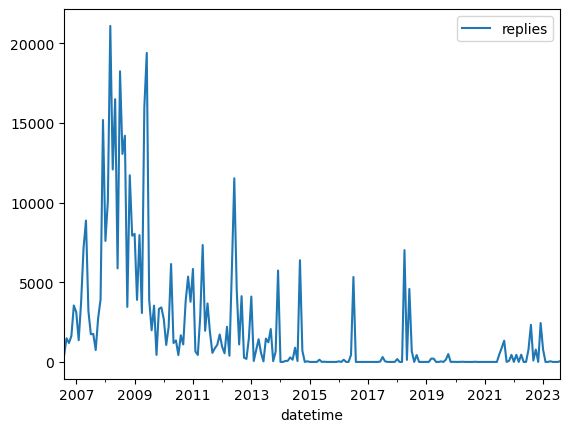

In [243]:
# Plotting number of replies
repl_time_series_ronaldo = repl_count_df_ronaldo.resample('1M').sum()
repl_time_series_ronaldo.plot()
plt.show()

In [244]:
view_count_df_ronaldo

,views
datetime,
2006-08-24 19:46:00,14797
2006-08-24 20:29:00,14797
2006-08-25 16:52:00,9042
2006-08-26 11:31:00,1886
2006-08-27 10:25:00,1886
...,...
2022-12-20 10:54:00,1835
2023-01-15 10:13:00,49856
2023-04-14 23:30:00,3674


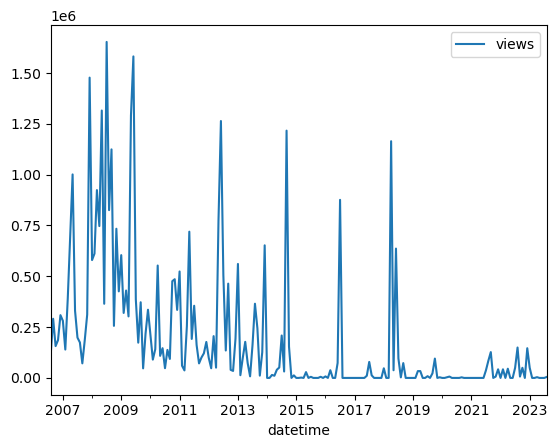

In [245]:
# Plotting number of views
view_time_series_ronaldo = view_count_df_ronaldo.resample('1M').sum()
view_time_series_ronaldo.plot()
plt.show()

In [246]:
repl_count_df_messi = pd.DataFrame(columns=['datetime', 'replies'])
view_count_df_messi = pd.DataFrame(columns=['datetime', 'views'])

# Making a series for number of replies and views
for i in range(len(data_clean_datetime_messi)):
    post_date = data_clean_datetime_messi['datetime'][i]
    if post_date in repl_count_df_messi['datetime'].unique():
        repl_count_df_messi.loc[repl_count_df_messi['datetime'] == post_date, 'replies'] += data_clean_datetime_messi['replies'][i]
    else:
        new_row = {'datetime':post_date, 'replies':data_clean_datetime_messi['replies'][i]}
        repl_count_df_messi.loc[len(repl_count_df_messi)] = new_row
    if post_date in view_count_df_messi['datetime'].unique():
        view_count_df_messi.loc[view_count_df_messi['datetime'] == post_date, 'views'] += data_clean_datetime_messi['views'][i]
    else:
        new_row = {'datetime':post_date, 'views':data_clean_datetime_messi['views'][i]}
        view_count_df_messi.loc[len(view_count_df_messi)] = new_row

repl_count_df_messi = repl_count_df_messi.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')
view_count_df_messi = view_count_df_messi.sort_values(by='datetime').reset_index(drop=True).set_index('datetime')

In [247]:
repl_count_df_messi

,replies
datetime,
2006-08-26 09:29:00,31
2006-08-30 14:30:00,2
2006-09-03 11:46:00,6
2006-09-04 07:21:00,6
2006-09-28 17:44:00,0
...,...
2022-12-19 22:46:00,546
2023-01-23 20:00:00,776
2023-01-23 21:15:00,776


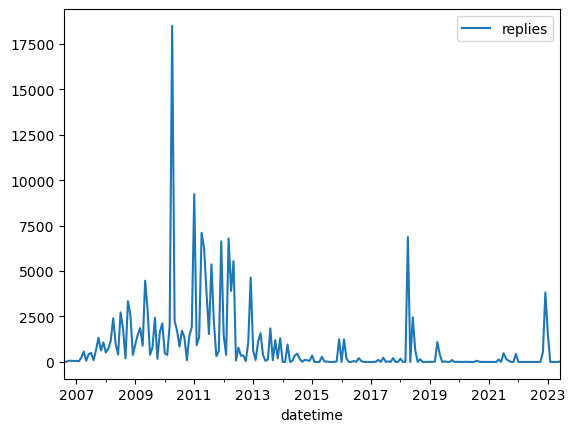

In [248]:
# Plotting number of replies
repl_time_series_messi = repl_count_df_messi.resample('1M').sum()
repl_time_series_messi.plot()
plt.show()

In [249]:
view_count_df_messi

,views
datetime,
2006-08-26 09:29:00,9042
2006-08-30 14:30:00,1659
2006-09-03 11:46:00,2486
2006-09-04 07:21:00,2556
2006-09-28 17:44:00,610
...,...
2022-12-19 22:46:00,30873
2023-01-23 20:00:00,49856
2023-01-23 21:15:00,49856


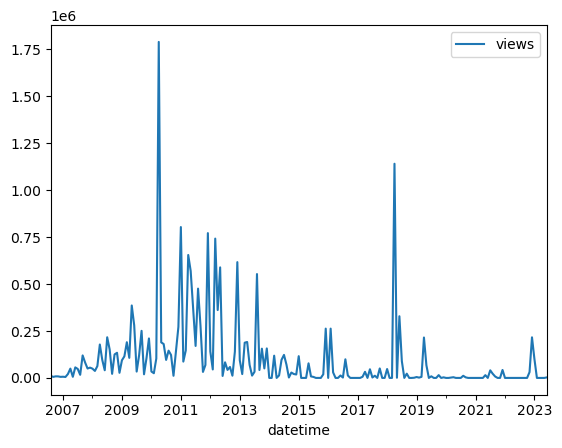

In [250]:
# Plotting number of views
view_time_series_messi = view_count_df_messi.resample('1M').sum()
view_time_series_messi.plot()
plt.show()

In [195]:
# using regex tokenizer to be more 'precise'
reg_tokenizer = RegexpTokenizer(regexpr)

# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk, a few other twitter specific terms like 'TIL' and 'AMA', and the word 'esport' specifically
lStopwords = nltk.corpus.stopwords.words('english') + lPunct
# Using the Porter stemmer
redditStemmer = nltk.stem.PorterStemmer()

In [252]:
# The term frequency counter in post text for ronaldo
term_freq_count_text_ronaldo = Counter() # The term frequency counter in text

# process all post titles
for i in range(len(data_clean_datetime_ronaldo)):
    text_preproc = data_clean_datetime_ronaldo['text'][i]
    # tokenise, filter stopwords and get convert to lower case
    lTokens = proc_text(text=text_preproc, tokenizer=reg_tokenizer, stemmer=redditStemmer, stopwords=lStopwords)

    # update count
    term_freq_count_text_ronaldo.update(lTokens)

In [253]:
# print out most common terms in post texts
for term, count in term_freq_count_text_ronaldo.most_common(num_freq_term):
    print(term + ': ' + str(count))

ronaldo: 5096
player: 1510
wa: 1295
hi: 1175
thi: 1105
ha: 992
play: 929
like: 921
would: 795
team: 768
cristiano: 756
game: 739
unit: 737
think: 713
get: 689
one: 689
u: 689
world: 685
madrid: 670
go: 664
goal: 659
best: 655
man: 652
real: 643
say: 612


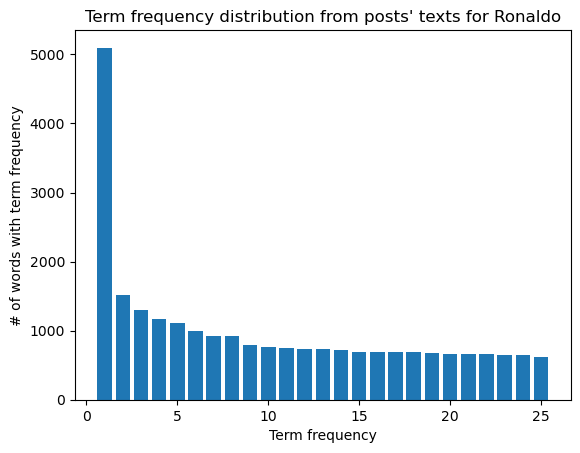

In [258]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text.most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Ronaldo")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

In [255]:
# The term frequency counter in post text in messi
term_freq_count_text_messi = Counter() # The term frequency counter in text

# process all post titles
for i in range(len(data_clean_datetime_messi)):
    text_preproc = data_clean_datetime_messi['text'][i]
    # tokenise, filter stopwords and get convert to lower case
    lTokens = proc_text(text=text_preproc, tokenizer=reg_tokenizer, stemmer=redditStemmer, stopwords=lStopwords)

    # update count
    term_freq_count_text_messi.update(lTokens)

In [256]:
# print out most common terms in post texts
for term, count in term_freq_count_text_messi.most_common(num_freq_term):
    print(term + ': ' + str(count))

messi: 1728
player: 624
ronaldo: 465
wa: 430
play: 419
world: 381
hi: 354
best: 351
thi: 350
ha: 330
like: 326
would: 324
lionel: 289
team: 286
game: 276
goal: 275
think: 254
one: 248
good: 239
get: 224
time: 220
better: 219
barca: 217
barcelona: 211
year: 205


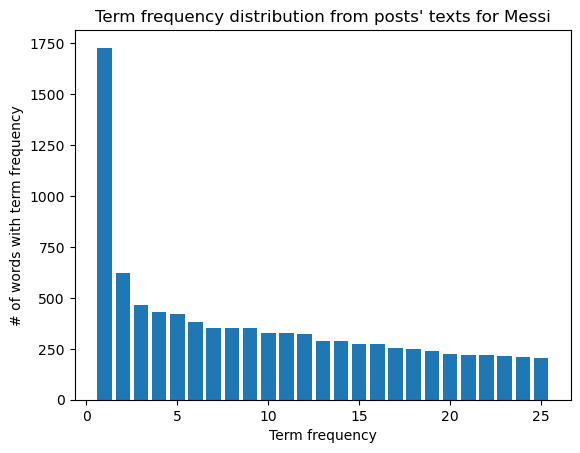

In [259]:
# construct the x and y values
y = [count for tag, count in term_freq_count_text_messi.most_common(num_freq_term)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution from posts' texts for Messi")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

Sentiment Analysis for 'Ronaldo' in Australia

In [202]:
posWordFile = 'positive-words.txt' # input file of set of postive words
negWordFile = 'negative-words.txt' # input file of set of negative words

flagPrint = False # flag to determine whether to print out tweets and their sentiment

regexpr = r'\w+' # Regular Expression for tokenizer

In [203]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [214]:
def vaderSentimentAnalysis(data, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    
    for i in range(len(data)):
        post_text = data['text'][i]
        post_date = data['datetime'][i]

        # pre-process the post text
        lTokens = redditProcessor.process(post_text)

        # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
        # see workshop sheet for what dSentimentScores holds
        dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

        # save the date and sentiment of each post (used for time series)
        lSentiment.append([pd.to_datetime(post_date, unit='s'), dSentimentScores['compound']])

        # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
        # of positive and negative words, we cannot use colorama to label each token
        if bPrint:
            vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

In [212]:
# construct the reddit pro-processing object
# use regex tokenizer
reg_tokenizer = RegexpTokenizer(regexpr)
lPunct = list(string.punctuation)
# standard 'English' stopwords
lStopwords = stopwords.words('english') + lPunct

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(reg_tokenizer, lStopwords)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [260]:
# compute the sentiment
text_l_sentiment_ronaldo = [] # List of sentiments for ronaldo
text_l_sentiment_ronaldo = vaderSentimentAnalysis(data_clean_datetime_ronaldo, flagPrint, redditProcessor)
text_l_sentiment_messi = [] # List of sentiments for messi
text_l_sentiment_messi = vaderSentimentAnalysis(data_clean_datetime_messi, flagPrint, redditProcessor)

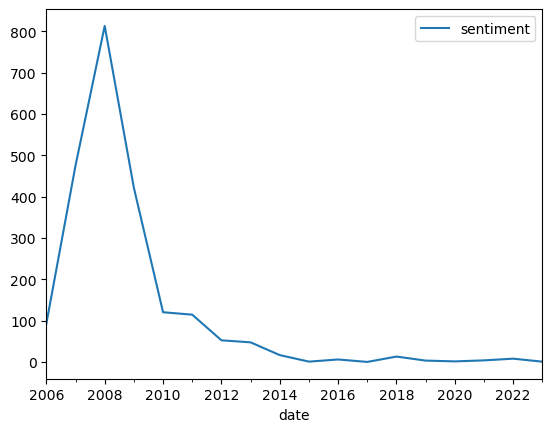

In [265]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
post_senti_series_ronaldo = pd.DataFrame(text_l_sentiment_ronaldo, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
post_senti_series_ronaldo.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
post_senti_series_ronaldo[['sentiment']] = post_senti_series_ronaldo[['sentiment']].apply(pd.to_numeric)

post_senti_newSeries = post_senti_series_ronaldo.resample('1Y').sum()
# this plots and shows the time series
post_senti_newSeries.plot()
plt.show()

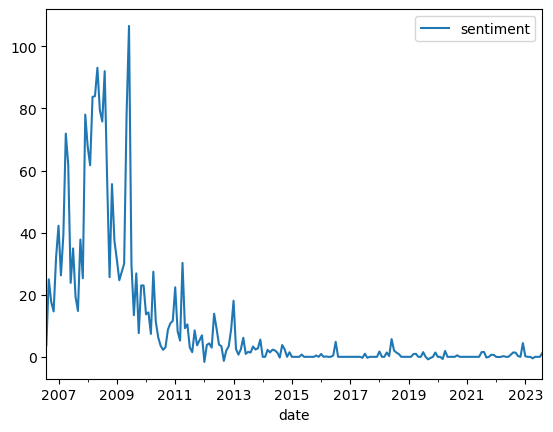

In [266]:
post_senti_newSeries_ronaldo = post_senti_series_ronaldo.resample('1M').sum()
# this plots and shows the time series
post_senti_newSeries_ronaldo.plot()
plt.show()

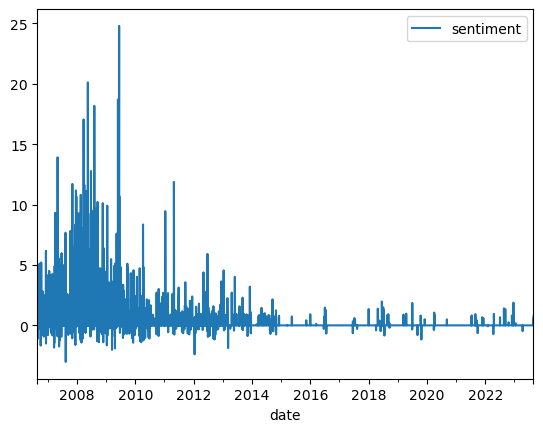

In [267]:
post_senti_newSeries_ronaldo = post_senti_series_ronaldo.resample('1D').sum()
# this plots and shows the time series
post_senti_newSeries_ronaldo.plot()
plt.show()

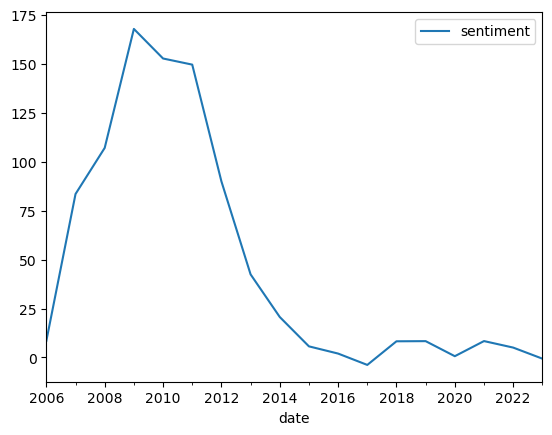

In [268]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
post_senti_series_messi = pd.DataFrame(text_l_sentiment_messi, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
post_senti_series_messi.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
post_senti_series_messi[['sentiment']] = post_senti_series_messi[['sentiment']].apply(pd.to_numeric)

post_senti_newSeries = post_senti_series_messi.resample('1Y').sum()
# this plots and shows the time series
post_senti_newSeries.plot()
plt.show()

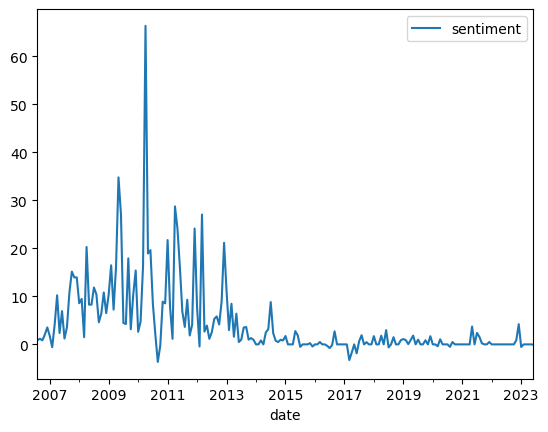

In [269]:
post_senti_newSeries_messi = post_senti_series_messi.resample('1M').sum()
# this plots and shows the time series
post_senti_newSeries_messi.plot()
plt.show()

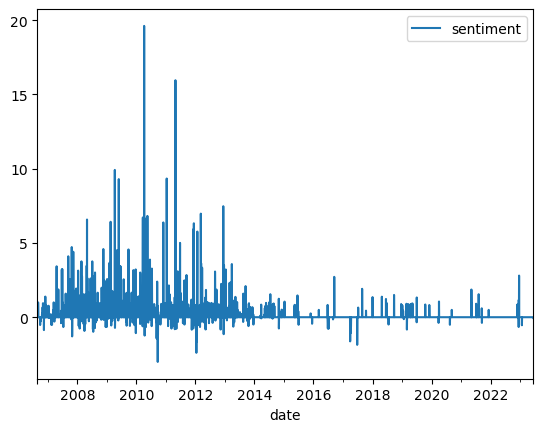

In [270]:
post_senti_newSeries_messi = post_senti_series_messi.resample('1D').sum()
# this plots and shows the time series
post_senti_newSeries_messi.plot()
plt.show()